# Rt Live Model

Processing Russia...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, seed, log_r_t]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 377 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Processing Italy...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, seed, log_r_t]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 456 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Processing Germany...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, seed, log_r_t]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 432 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Processing France...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, seed, log_r_t]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 565 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


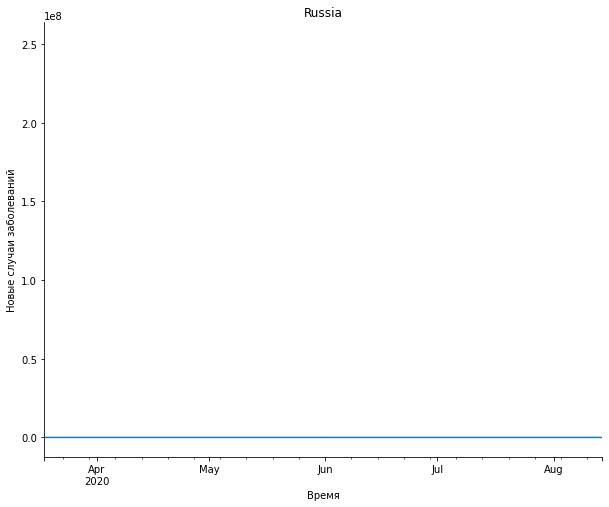

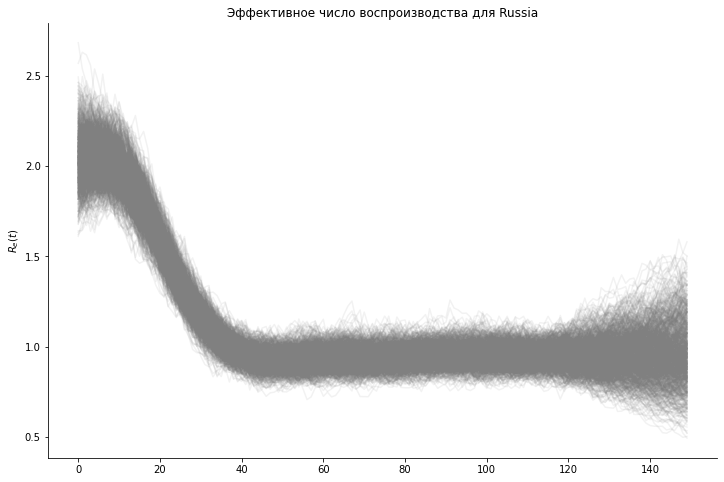

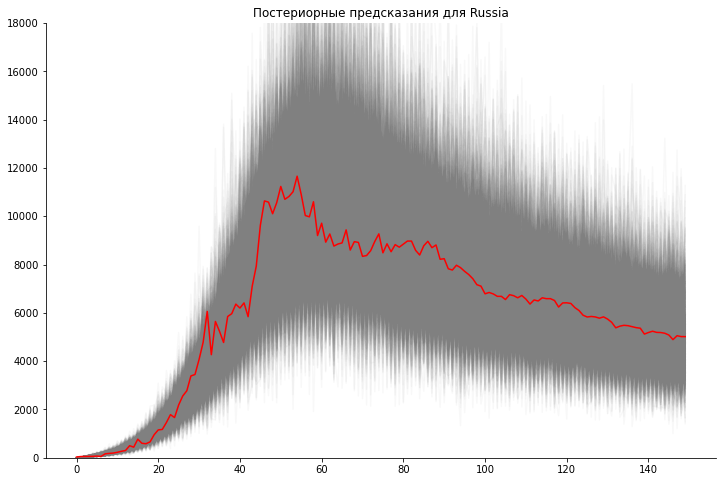

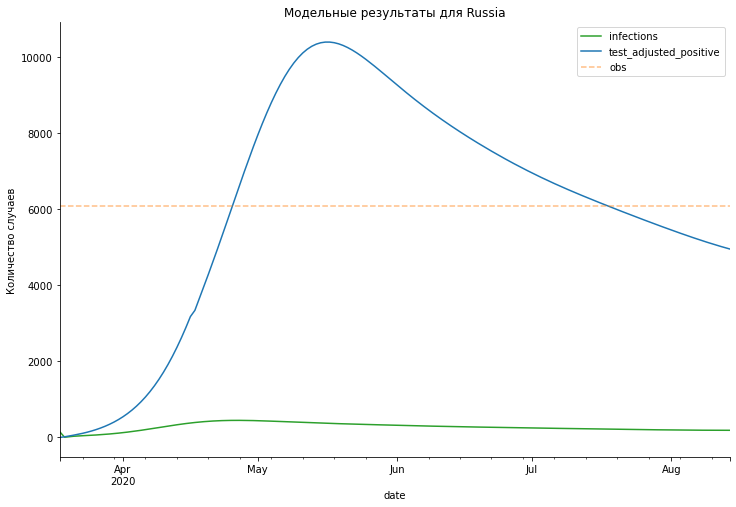

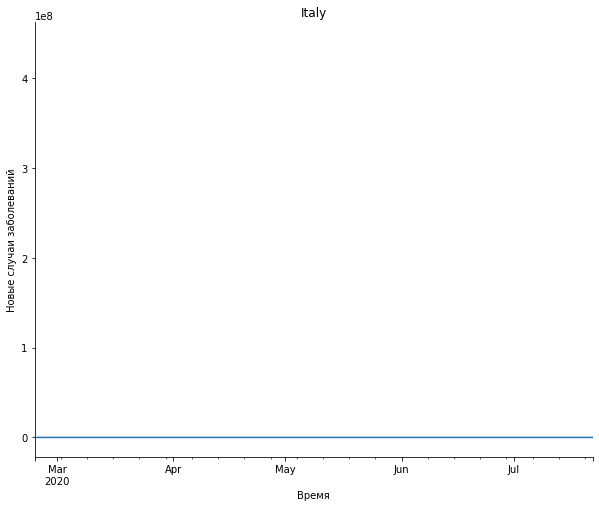

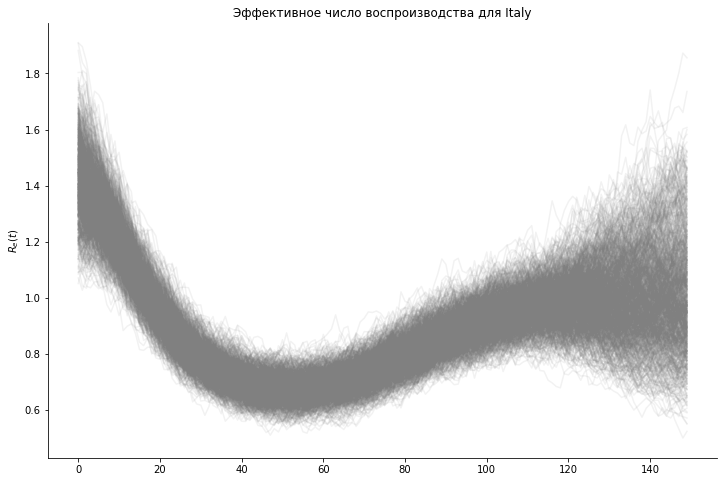

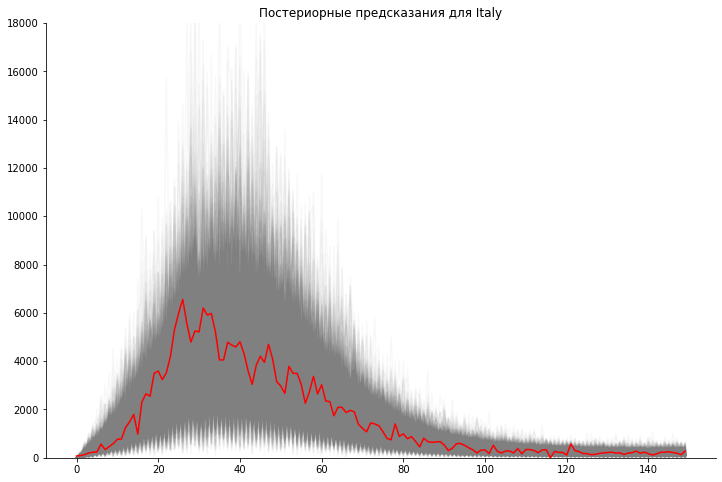

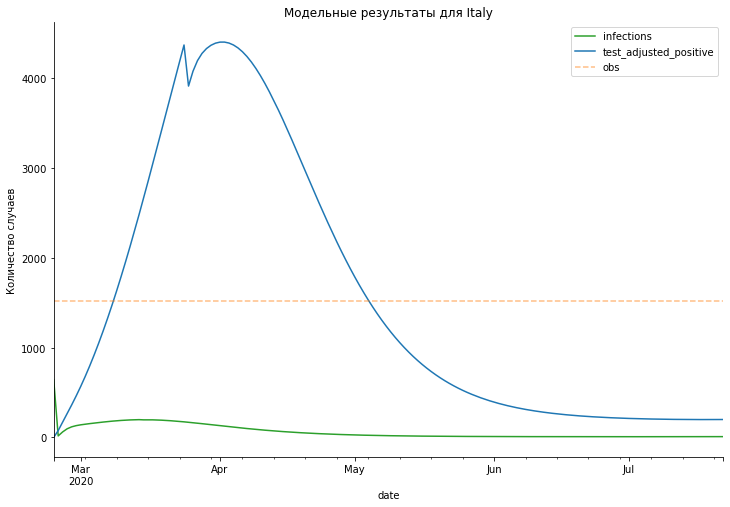

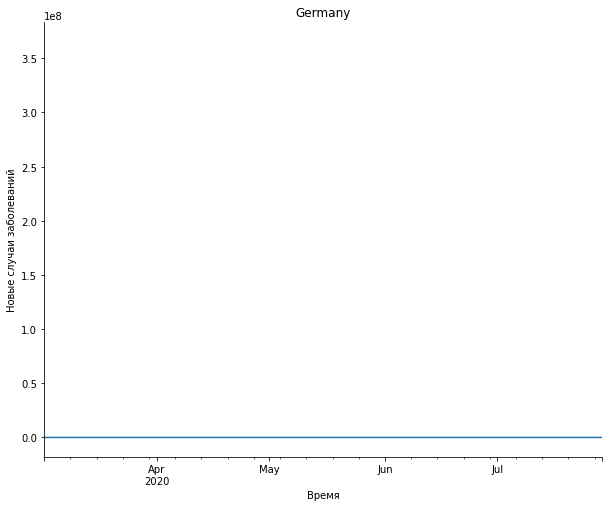

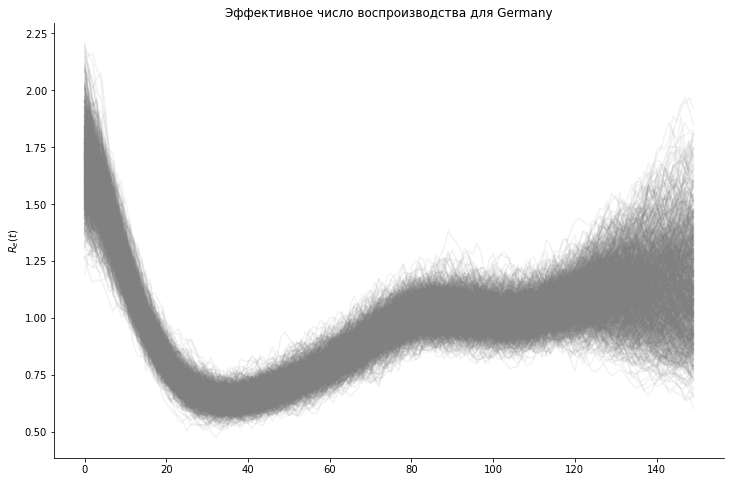

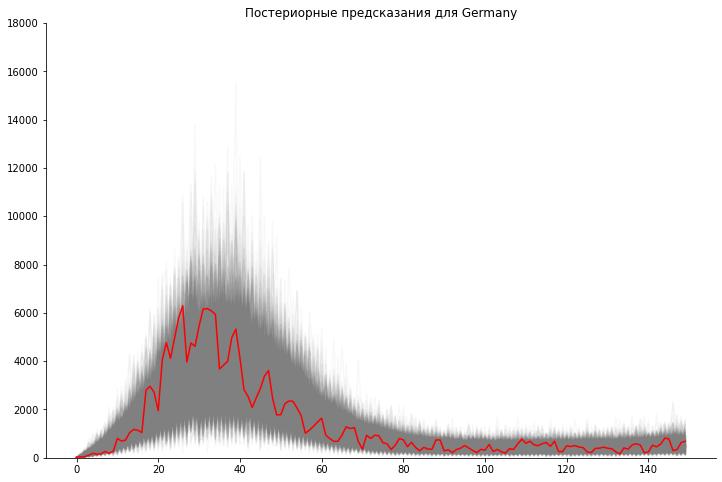

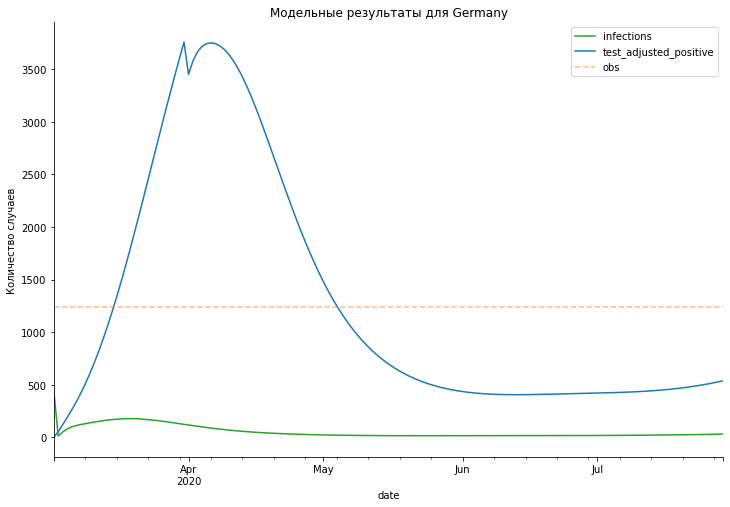

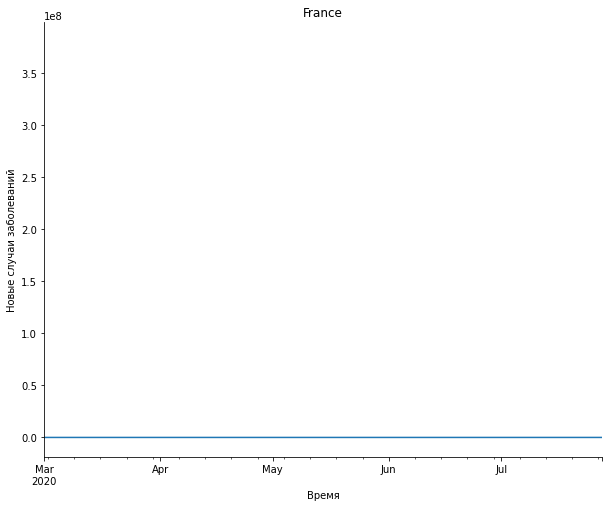

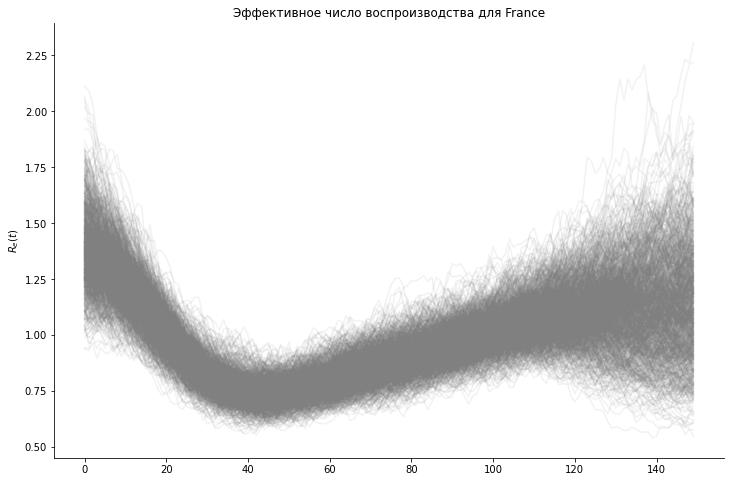

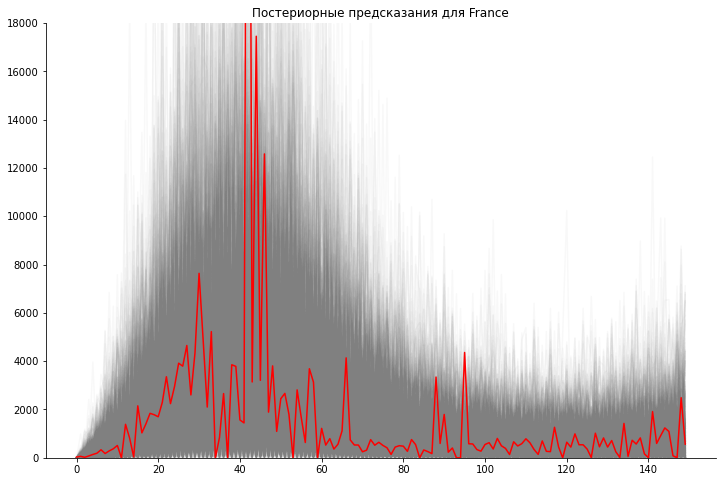

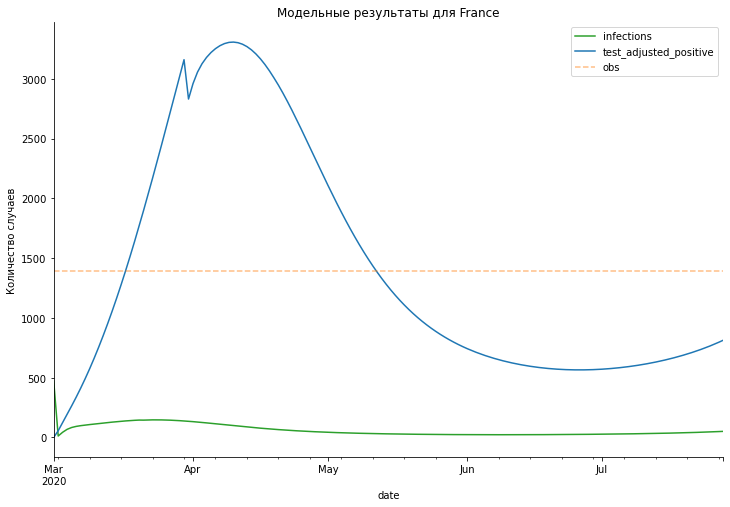

In [4]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from covid.data import load_owid_covid_data, summarize_inference_data
from covid.models.generative import GenerativeModel


def sampler_kwargs(
    chains: int = 1,
    cores: int = 1,
    return_inferencedata: bool = True,
    tune: int = None,
    draws: int = None
):
    if tune is None and draws is None:
        return {
            "chains": 1,
            "cores": 1,
            "return_inferencedata": return_inferencedata,
            "random_seed": 42,
        }
    else:
        return {
            "chains": 1,
            "cores": 1,
            "return_inferencedata": return_inferencedata,
            "random_seed": 42,
            "tune": tune,
            "draws": draws
        }


def analyze_countries(countries: list, file_path='./results'):
    """
    Выполняет анализ для списка стран, строит графики и сохраняет результаты.
    
    Параметры:
    - countries: список названий стран для анализа.
    - df: датафрейм с данными по COVID-19.
    - file_path: путь для сохранения графиков и таблиц.

    Возвращает:
    - results: словарь, где ключ - название страны, а значение - датафрейм с результатами.
    """
    results = {}
    os.makedirs(file_path, exist_ok=True)

    df = load_owid_covid_data(file_path='./data/owid-covid-data.csv', filter_n_days_100=2)

    for country in countries:
        print(f"Processing {country}...")

        # Фильтрация данных по стране и ограничение по времени
        df_country = df.loc[df['country'] == country].iloc[1:151]

        # Создание модели для страны
        gm = GenerativeModel(country, df_country)
        model = gm.build()

        with model:
            # Предварительная выборка и выборка по трассировке
            prior_pred = pm.sample_prior_predictive()
            _kwargs = sampler_kwargs()  # Получение настроек для выборки
            trace = pm.sample(**_kwargs)
            post_pred = pm.sample_posterior_predictive(trace)

        # Создание и сохранение графика с новыми случаями
        fig, ax = plt.subplots(figsize=(10, 8))
        new_cases = df_country.new_cases
        new_cases.plot(ax=ax)
        ax.plot(prior_pred["obs"].T, color="0.5", alpha=0.05)
        ax.set(ylabel="Новые случаи заболеваний", xlabel='Время', title=f'{country}')
        sns.despine()
        fig.savefig(f"{file_path}/{country}_new_cases.png")
        
        # Построение Rt графика и его сохранение
        post = trace.posterior["r_t"].sel(chain=0).to_dataframe()["r_t"].unstack().T
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.plot(post, color="0.5", alpha=0.1)
        ax.set(title=f"Эффективное число воспроизводства для {country}", ylabel="$R_e(t)$")
        sns.despine()
        fig.savefig(f"{file_path}/{country}_r_t.png")

        # Построение графиков для предсказанных значений и наблюдений
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.plot(post_pred["obs"].T, color="0.5", alpha=0.05)
        ax.plot(new_cases.values, color="r")
        ax.set(ylim=(0, 18000), title=f"Постериорные предсказания для {country}")
        sns.despine()
        fig.savefig(f"{file_path}/{country}_posterior_predictions.png")

        # Суммирование и сохранение результатов в датафрейм
        result = summarize_inference_data(trace, post_pred, df_country)
        for column in ["mean", "median", "lower_80", "upper_80", "infections", "test_adjusted_positive", "obs"]:
            result[column] = result[column].transform(lambda x: x.values)
        results[country] = result
        
        # График для итоговых результатов и его сохранение
        fig, ax = plt.subplots(figsize=(12, 8))
        result.infections.plot(c="C2", label="infections")
        result.test_adjusted_positive.plot(c="C0", label="test_adjusted_positive")
        result.obs.plot(c="C1", alpha=0.5, label="obs", style="--")
        ax.legend()
        ax.set(title=f"Модельные результаты для {country}", ylabel="Количество случаев")
        sns.despine()
        fig.savefig(f"{file_path}/{country}_model_results.png")

    return results


if __name__ == "__main__":
     analyze_countries(['Russia', 'Italy', 'Germany', 'France'])